# Introduction to Nvidia GPU Hardware & Numba Cuda Kernels

## GPU Architecture

![image.png](attachment:image.png)

### What is Flynn’s Taxonomy?
Flynn’s Taxonomy is a categorization of computer architectures by Stanford University’s Michael J. Flynn. The basic idea behind Flynn’s Taxonomy is simple: computations consist of 2 streams (data and instructional streams) that can be processed in sequence(1 stream at a time) or in parallel (multiple streams at once). Two data streams with two possible methods to process them leads to the 4 different categories in Flynn’s Taxonomy. Let’s take a look at each.

#### Single Instruction Single Data (SISD)
SISD stream is an architecture where a single instruction stream (e.g. a program) executes on one data stream. This architecture is used in older computers with a single-core processor, as well as many simple compute devices.

#### Single Instruction Multiple Data (SIMD)
A SIMD stream architecture has a single control processor and instruction memory, so only one instruction can be run at any given point in time. That single instruction is copied and ran across each core at the same time. This is possible because each processor has its own dedicated memory which allows for parallelism at the data-level (a.k.a. “data parallelism”). 

The fundamental advantage of SIMD is that data parallelism allows it to execute computations quickly (multiple processors doing the same thing) and efficiently (only one instruction unit). 

#### Multiple Instruction Single Data (MISD)
MISD stream architecture is effectively the reverse of SIMD architecture. With MISD multiple instructions are performed on the same data stream. The use cases for MISD are very limited today. Most practical applications are better addressed by one of the other architectures. 

#### Multiple Instruction Multiple Data (MIMD)
MIMD stream architecture offers parallelism for both data and instruction streams. With MIMD, multiple processors execute instruction streams independently against different data streams. 

#### What makes SIMD best for GPUs? 
Now that we understand the different architectures, let’s consider why SIMD is the best choice for GPUs. The answer becomes intuitive when you understand that fundamentally graphics processing -- and many other common GPU computing use cases -- are simply running the same mathematical function over and over again at scale. In this case, many processors running the same instruction on multiple data sets is ideal.

Case in point: adjusting video brightness of a pixel relies on simple arithmetic using RGB (red green blue) values. Executing the same function multiple times is what’s needed to produce the desired result, and SIMD is ideal for that use case. Conversely, MIMD is most effective in applications that call for multiple discrete computations to be executed such as computer-aided design (CAD). 

#### What about SIMT?
If you’re familiar with GPUs, you’ve likely heard the term single instruction multiple threads (SIMT). So where does SIMT fit into Flynn’s Taxonomy? SIMT can be viewed as an extension of SIMD. It adds multithreading to SIMD which improves efficiency as there is less instruction fetching overhead. 

![image-2.png](attachment:image-2.png)

### CUDA parallel computing platform 
Stands for **Compute Unified Device Architecture** (CUDA), providing an API that enables developers to optimize how GPU resources are used -- without the need for specialized graphics programming knowledge -- CUDA has gone a long way in making GPUs useful for general purpose computing. 

#### CUDA compute hierarchy 

##### Threads 
A thread -- or CUDA core -- is a parallel processor that computes floating point math calculations in an Nvidia GPU. All the data processed by a GPU is processed via a CUDA core. Modern GPUs have hundreds or even thousands of CUDA cores.  Each CUDA core has its own memory register that is not available to other threads.

While the relationship between compute power and CUDA cores is not perfectly linear, generally speaking -- and assuming all else is equal -- the more CUDA cores a GPU has, the more compute power it has. However, there are a variety of exceptions to this general idea. For example, different GPU microarchitectures can impact performance and make a GPU with fewer CUDA cores more powerful  

##### Thread blocks 
As the name implies, a thread block -- or CUDA block -- is a grouping of CUDA cores (threads) that can be executed together in series or parallel. The logical grouping of cores enables more efficient data mapping. Thread blocks share memory on a per-block basis. Current CUDA architecture caps the amount of threads per block at 1024. Every thread in a given CUDA block can access the same shared memory (more on the different types of memory below). 

##### Kernel grids
The next layer of abstraction up from thread blocks is the kernel grid. Kernel grids are groupings of thread blocks on the same kernel. Grids can be used to perform larger computations in parallel (e.g. those that require more than 1024 threads), however since different thread blocks cannot use the same shared memory, the same synchronization that occurs at the block-level does not occur at the grid-level. 

#### Cuda memory hirerchy
Like compute resources, memory allocation follows a specific hierarchy in CUDA. While the CUDA compiler automatically handles memory allocation, CUDA developers can and do program to optimize memory usage directly. Here are the key concepts to understand about the CUDA memory hierarchy. 

##### Registers
Registers are the memory that gets allocated to individual threads (CUDA cores). Because registers exist in “on-chip” memory and are dedicated to individual threads, the data stored in a register can be processed faster than any other data.  The allocation of memory in registers is a complicated process and is handled by compilers as opposed to being controlled by software CUDA developers write.

##### Read-only memory
Read-only (RO) is on-chip memory on GPU streaming multiprocessors. It is used for specific tasks such as texture memory which can be accessed using CUDA texture functions. In many cases, fetching data from read-only memory can be faster and more efficient than using global memory. 

##### L1 Cache/shared memory
Layer 1 (L1)  cache and shared memory is on-chip memory that is shared within thread blocks (CUDA blocks). Because L1 cache and shared memory exists on-chip, it is faster than both L2 cache and global memory. The fundamental difference between L1 cache and shared memory is: shared memory usage is controlled via software while L1 cache is controlled by hardware. 

##### L2 Cache
Layer 2 cache can be accessed by all threads in all CUDA blocks. L2 cache stores both global and local memory. Retrieving data from L2 cache is faster than retrieving data from global memory. 

##### Global memory
Global memory is the memory that resides in a device’s DRAM. Using a CPU analogy, global memory is comparable to RAM. Fetching data from global memory is inherently slower than fetching it from L2 cache.  

![image-3.png](attachment:image-3.png)


### Terminology
* Host - the CPU and its memory
* Device - the GPU and its memory
* Kernel Function - a function that runs on the **device** but launched from the **host**
* Device Function - a function that runs on the **device** but launched from the **kernel**


### Simple Cuda Workflow
![image-5.png](attachment:image-5.png)

![image-6.png](attachment:image-6.png)

![image-4.png](attachment:image-4.png)


### Architecture vs Microarchitecture
Architecture or ISA (Instruction set architecture) is an abstraction of data-types, registers and instruction types (add, subtract, multiply, etc..) to define a behavior of computational module.

Microarchitecture is the way a given ISA (architecture) is implemented on a certain processor.

Nvidia had launched throughout the years many different microarchitectures for their GPUs with different modifications to make the given ISA perform certain operations more efficiently on different hardwares developed by NVIDIA.

Some of the recent microarchitectures (sorted from old to new):
* Tesla
* Fermi
* Kepler
* Maxwell
* Pascal
* Volta
* Turing
* Ampere

## Numba - Setup

In [ ]:
!pip install numba

## Writing Cuda Kernels - Numba

While targeting ufuncs with the cuda syntax is the most straightforward way to access the GPU with Numba, it may not be flexible enough for your needs. If you want to write a more detailed GPU program, at some point you are probably going to need to write CUDA kernels.

As discussed in the lecture, the CUDA programming model allows you to abstract the GPU hardware into a software model composed of a grid containing blocks of threads. These threads are the smallest individual unit in the programming model, and they execute together in groups (traditionally called warps, consisting of 32 thread each). Determiming the best size for your grid of thread blocks is a complicated problem that often depends on the specific algorithm and hardware you're using, but here a few good rules of thumb:

* the size of a block should be a multiple of 32 threads, with typical block sizes between 128 and 512 threads per block.
* the size of the grid should ensure the full GPU is utilized where possible. Launching a grid where the number of blocks is 2x-4x the number of "multiprocessors" on the GPU is a good starting place. Something in the range of 20 - 100 blocks is usually a good starting point.
* The CUDA kernel launch overhead does depend on the number of blocks, so it may not be best to launch a grid where the number of threads equals the number of input elements when the input size is very big. We'll show a pattern for dealing with large inputs below.


As a first example, let's return to our vector addition function, but this time, we'll target it with the cuda.jit decorator:

In [ ]:
from numba import cuda

@cuda.jit
def add_kernel(x, y, out):
    tidx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    bidx = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_dimx = cuda.blockDim.x  # number of threads per block
    grid_dimx = cuda.gridDim.x    # number of blocks in the grid
    
    start = tidx + bidx * block_dimx
    stride = block_dimx * grid_dimx

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]


That's a lot more typing than our ufunc example, and it is much more limited: it only works on 1D arrays, it doesn't verify input sizes match, etc. Most of the function is spent figuring out how to turn the block and grid indices and dimensions into unique offsets in the input arrays. The pattern of computing a starting index and a stride is a common way to ensure that your grid size is independent of the input size. The striding will maximize bandwidth by ensuring that threads with consecuitive indices are accessing consecutive memory locations as much as possible. Thread indices beyond the length of the input (x.shape[0], since x is a NumPy array) automatically skip over the for loop.

Let's call the function now on some data:

In [ ]:
import numpy as np


n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])


The calling syntax is designed to mimic the way CUDA kernels are launched in C, where the number of blocks per grid and threads per block are specified in the square brackets, and the arguments to the function are specified afterwards in parentheses.

Note that, unlike the ufunc, the arguments are passed to the kernel as full NumPy arrays. A thread within the kernel can access any element in the array it wants, regardless of its position in the thread grid. This is why CUDA kernels are significantly more powerful than ufuncs. (But with great power, comes a greater amount of typing...)

Numba has created some helper functions to cut down on the typing. We can write the previous kernel much more simply as: (http://numba.pydata.org/numba-doc/dev/cuda/kernels.html#absolute-positions)

In [ ]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # the 1 argument means a one dimensional thread grid, this returns a single value
    stride = cuda.gridsize(1) # ditto

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

As before, using NumPy arrays forces Numba to allocate GPU memory, copy the arguments to the GPU, run the kernel, then copy the argument arrays back to the host. This not very efficient, so you will often want to allocate device arrays.

#### Exercise - 1
Allocate device arrays for x, y, and the output, then try out your new Cuda kernel using the pre-copied device arrays. Compare the time to a version without moving the data first.

In [ ]:
# Add your code here

### Atomic Operations and avoiding Race Conditions
CUDA, like many general purpose parallel execution frameworks, makes it possible to have race conditions in your code. A race condition in CUDA arises when threads read or write a memory location that might be modified by another independent thread. Generally speaking, you need to worry about:

__read-after-write hazards__: One thread is reading a memory location at the same time another thread might be writing to it.

__write-after-write hazards__: Two threads are writing to the same memory location, and only one write will be visible when the kernel is complete.

A common strategy to avoid both of these hazards is to organize your CUDA kernel algorithm such that each thread has exclusive responsibility for unique subsets of output array elements, and/or to never use the same array for both input and output in a single kernel call. (Iterative algorithms can use a double-buffering strategy if needed, and switch input and output arrays on each iteration.) However, there are many cases where different threads need to combine results. Consider something very simple, like: "every thread increments a global counter." Implementing this in your kernel requires each thread to:

* Read the current value of a global counter.
* Compute counter + 1.
* Write that value back to global memory. However, there is no guarantee that another thread has not changed the global counter between steps 1 and 3. To resolve this problem, CUDA provides __"atomic operations"__ which will read, modify and update a memory location in one, indivisible step. Numba supports several of these functions, described here.

As an example, let's make a thread counter kernel:

In [ ]:
@cuda.jit
def thread_counter_race_condition(global_counter):
    global_counter[0] += 1  # This is bad
    
@cuda.jit
def thread_counter_safe(global_counter):
    cuda.atomic.add(global_counter, 0, 1)  # Safely add 1 to offset 0 in global_counter array

In [ ]:
# This gets the wrong answer
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_race_condition[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

In [ ]:
# This works correctly
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_safe[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

#### Exercise - 2
Let's practice writing a function that requires an atomic operation - a histogramming kernel. This will take an array of input data, a range and a number of bins, and count how many of the input data elements land in each bin. Below is an example CPU implementation of histogramming:

In [ ]:
def cpu_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    # Note that we don't have to pass in nbins explicitly, because the size of histogram_out determines it
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # This is a very slow way to do this with NumPy, but looks similar to what you will do on the GPU
    for element in x:
        bin_number = np.int32((element - xmin)/bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            # only increment if in range
            histogram_out[bin_number] += 1

In [ ]:
x = np.random.normal(size=10000, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

cpu_histogram(x, xmin, xmax, histogram_out)

histogram_out

In the space below, create a cuda version of this kernel, then run it to check that you get the same answer as the CPU version.

Hint: You can use much of the same syntax that we used in the CUDA addition kernel.

In [ ]:
@cuda.jit
def cuda_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    
    # add code here

### Multi-dimensional grids
For some problems, it makes sense to define a two- or three-dimensional grid of thread blocks. That way, when you're indexing a single thread, you can map it to, say, the pixel position in an image. Multi-dimensional grids are created by passing tuples to the kernel function. You can ensure that you launch a big enough grid by calculating the size of each dimension as a function of the array size and number of threads per block:

In [1]:
!apt update && apt install libgl1-mesa-glx -y
!pip install opencv-python

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 

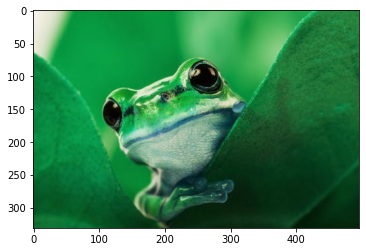

In [4]:
import cv2
import requests
import matplotlib.pyplot as plt

r = requests.get('https://images.theconversation.com/files/387712/original/file-20210304-15-n1wg4d.jpg?ixlib=rb-1.1.0&rect=133%2C110%2C3701%2C2473&q=45&auto=format&w=496&fit=clip', allow_redirects=True)
open('frog.jpg', 'wb').write(r.content)

test_image = cv2.imread('frog.jpg')

plt.figure()
plt.imshow(test_image)

Calculate blocks per image axis:

In [5]:
threadsperblock = 32
xblocks = (test_image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (test_image.shape[0] + (threadsperblock - 1)) // threadsperblock

print("Xblocks: ", xblocks)
print("Yblocks: ", yblocks)

Xblocks:  16
Yblocks:  11


Lets write and histogram function for an opencv image:

In [6]:
from numba import cuda

@cuda.jit
def cv_histogram(x, histogram_out):
    nbins = histogram_out.shape[1]
    bin_width = 255 / nbins ## depth of each color
    
    pos = cuda.grid(2)
    
    r = np.int32(x[pos[0], pos[1]][0] / bin_width)
    g = np.int32(x[pos[0], pos[1]][1] / bin_width)
    b = np.int32(x[pos[0], pos[1]][2] / bin_width)
    
    if r >= 0 and r < histogram_out.shape[1]:
        cuda.atomic.add(histogram_out[0], r, 1)
    if g >= 0 and g < histogram_out.shape[1]:
        cuda.atomic.add(histogram_out[1], g, 1)
    if b >= 0 and b < histogram_out.shape[1]:
        cuda.atomic.add(histogram_out[2], b, 1)

In [7]:
import numpy as np

histogram_out = np.zeros(shape=[3, 20], dtype=np.int32)

blocks_per_grid = (xblocks, yblocks)

cv_histogram[blocks_per_grid, (threadsperblock, threadsperblock)](test_image, histogram_out)

histogram_out

array([[126029,  11461,   6587,   4678,   4753,   4164,   3463,   2910,
          2748,   1749,   2091,   2127,   1989,   1520,    910,    574,
           660,    748,    908,    155],
       [131529,   9742,  12607,  15914,  29314,  30150,  12933,  11077,
          8734,   9761,  13242,  19971,  20362,  11302,   9698,   6509,
          2975,   2571,   1867,    175],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0]], dtype=int32)

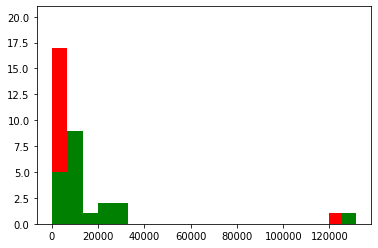

In [8]:
import matplotlib.pyplot as plt

plt.hist(histogram_out[0], bins=histogram_out.shape[1], color='red')
plt.hist(histogram_out[1], bins=histogram_out.shape[1], color='green')
plt.hist(histogram_out[2], bins=histogram_out.shape[1], color='blue')
plt.show()

#import matplotlib.pyplot as plt
 
#indexes = np.arange(len(histogram_out[0]))
 
#plt.bar(indexes, histogram_out[0], color='red')
#plt.bar(indexes, histogram_out[1], color='green')
#plt.bar(indexes, histogram_out[2], color='blue')
#plt.show()

### Exercise 3
Create a CPU & GPU (cuda) function with numba to convert colored input image to grayscale, compare time of execution for the both of them

Convert the image using the following formula

Gray = 0.2126*R + + 0.7152*B + 0.0722*G

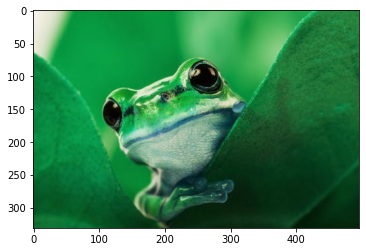

In [30]:
import cv2
import requests
import matplotlib.pyplot as plt

r = requests.get('https://images.theconversation.com/files/387712/original/file-20210304-15-n1wg4d.jpg?ixlib=rb-1.1.0&rect=133%2C110%2C3701%2C2473&q=45&auto=format&w=496&fit=clip', allow_redirects=True)
open('frog.jpg', 'wb').write(r.content)

test_image = cv2.imread('frog.jpg')

plt.figure()
plt.imshow(test_image)

In [31]:
threadsperblock = 32
yblocks = (test_image.shape[1] + (threadsperblock - 1)) // threadsperblock
xblocks = (test_image.shape[0] + (threadsperblock - 1)) // threadsperblock

print("Xblocks: ", xblocks)
print("Yblocks: ", yblocks)

Xblocks:  11
Yblocks:  16


In [32]:
from numba import cuda

@cuda.jit
def cv_gray_scale(x, gray_scale_x):    
    pos = cuda.grid(2)
    
    r = x[pos[0], pos[1]][0]
    g = x[pos[0], pos[1]][1]
    b = x[pos[0], pos[1]][2]

    gray_scale_x[pos[0], pos[1]] = np.int32(0.2126*r + 0.7152*g + 0.0722*b)

In [33]:
import numpy as np

gray_scale_x = np.zeros(shape=[331, 496], dtype=np.int32)

blocks_per_grid = (xblocks, yblocks)

cv_gray_scale[blocks_per_grid, (threadsperblock, threadsperblock)](test_image, gray_scale_x)

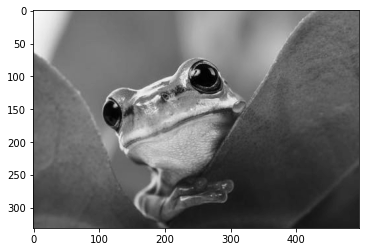

In [34]:
plt.figure()
plt.imshow(gray_scale_x, cmap='gray')